In [1]:
!pip install kmodes

In [3]:
!pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 653.6 kB/s eta 0:00:03
   ------- -------------------------------- 0.3/1.4 MB 2.7 MB/s eta 0:00:01
   ------------------------- -------------- 0.9/1.4 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 5.7 MB/s eta 0:00:00


In [4]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast
from sklearn.preprocessing import LabelEncoder
from kmodes.kmodes import KModes
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [5]:
# Load the datasets
movies_df = pd.read_csv("tmdb_5000_movies.csv")
credits_df = pd.read_csv("tmdb_5000_credits.csv")

# Merge the datasets on 'id'
df = movies_df.merge(credits_df, left_on='id', right_on='movie_id')

# Display the first few rows
df.head()


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [7]:
# Keep relevant columns for K-Modes and Association Mining
df = df[['title_x', 'original_language', 'genres', 'production_companies',
         'spoken_languages', 'cast', 'crew', 'keywords']]

# Rename for easier reference
df.rename(columns={'title_x': 'title'}, inplace=True)

# Function to convert stringified JSON into a list of names
def extract_names(obj):
    try:
        return [i['name'] for i in ast.literal_eval(obj)]
    except:
        return []

# Apply extraction to all relevant columns
for col in ['genres', 'production_companies', 'spoken_languages', 'cast', 'crew', 'keywords']:
    df[col] = df[col].apply(extract_names)

# Limit cast and crew to top 3 members for simplicity
df['cast'] = df['cast'].apply(lambda x: x[:3])
df['crew'] = df['crew'].apply(lambda x: x[:3])

# Create a combined features column for association mining
df['features'] = df['genres'] + df['production_companies'] + df['spoken_languages'] + df['cast'] + df['crew'] + df['keywords']

# Remove duplicate names within each row
df['features'] = df['features'].apply(lambda x: list(set(x)))


C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\DELL\AppData\Local\Temp\ipykernel_28524\3380888593.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='mako')


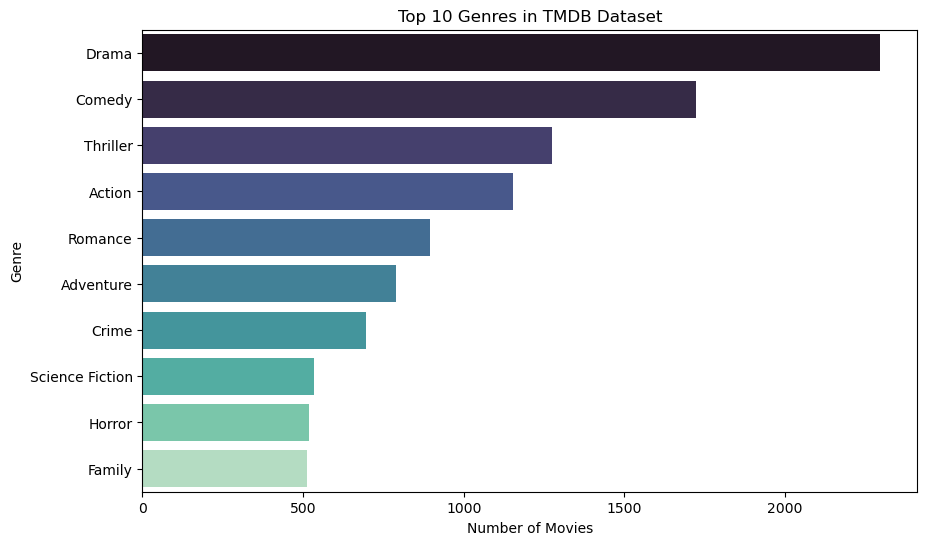

In [8]:
# Flatten all genres into a single list
all_genres = [g for sublist in df['genres'] for g in sublist]

# Plot top 10 genres
top_genres = pd.Series(all_genres).value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='mako')
plt.title("Top 10 Genres in TMDB Dataset")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()


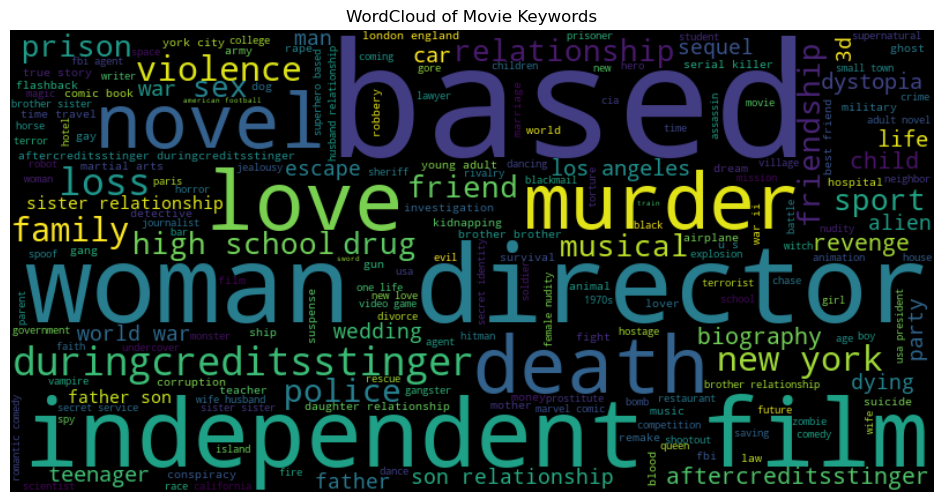

In [9]:
# Join all keywords into one large text string
all_keywords = ' '.join([' '.join(keywords) for keywords in df['keywords'] if isinstance(keywords, list)])

# Generate and plot the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_keywords)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Movie Keywords")
plt.show()


In [ ]:
#  Create a new 'main_genre' column in the original DataFrame
df['main_genre'] = df['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "Unknown")

# Create a new DataFrame with just the categorical features
df_kmodes = df[['original_language', 'main_genre']].copy()

# Encode categorical variables for K-Modes
from sklearn.preprocessing import LabelEncoder

le_lang = LabelEncoder()
le_genre = LabelEncoder()

df_kmodes['original_language'] = le_lang.fit_transform(df_kmodes['original_language'])
df_kmodes['main_genre'] = le_genre.fit_transform(df_kmodes['main_genre'])

# Run K-Modes clustering
from kmodes.kmodes import KModes

km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(df_kmodes)

# Assign the cluster labels back to the main DataFrame
df['cluster'] = clusters

#  View a sample of results
df[['title', 'original_language', 'main_genre', 'cluster']].head(20)
